# Workshop 1: An introduction and tabular methods.

*    Notebook for Workshop 1: An introduction and tabular methods.
*    Other parts of the workshops are available and can be found [here](https://netbrainml.github.io/workshop/).

### Table of Content
    
   1. [Introduction](#introduction)
   
    *[Creating our own Environment](#native)

    *[Using OpenAI Gym](#openai)

   1. [Dynamic Programming](#dynamicprogramming)
       
     *[Policy iteration](#policyiteration)
     
     *[Value iteration](#valueiteration)
     
   3. [Monte Carlo Methods](#montecarlo)
        
     *[First-Visit Monte Carlo Method with Exploring Starts+ Incremental Updates](#fesimc)
     
     *[Every-Visit Monte Carlo Method with epilson-soft Policy + Incremental Updates](#eegimc)
     
     *[Off-policy Monte Carlo Method with Importance Sampling](#mcopis)
   4. [Temporal Difference Learning](#tdlearning)
   
    *[SARSA](#sarsa)
     
    *[Expected SARSA](#esarsa)
    
    *[Q-Learning](#ql)
    
    *[Double Q-Learning](#dl)

   8. [n-Step Bootstrapping](#nsbs)
   
    *[n-Step SARSA](#nsarsa)

In [51]:
import pip
def import_or_install(package):
    try: __import__(package)
    except ImportError: pip.main(['install', package]) 
modules = ['emojis','numpy', 'gym', "git+https://github.com/MattChanTK/gym-maze.git"]
for m in modules:
    import_or_install(m)
from IPython.display import clear_output
clear_output(wait=False) 

# Introduction <a name="introduction">

## Creating our own Environment <a name="native">

In [52]:
import numpy as np
import emojis
from collections import defaultdict

boxes =    {0:":zero:",
            1:":two:",
            2:":four:",
            3:":white_square_button:",
            4:":black_large_square:",
            5:":black_square_button:",
            6:":white_check_mark:",
            7:":smile:",
            8:":x:",
            9:":ghost:"}

class LGM_Action_Space():
    def __init__(self):
        self.actions = {0:'up',1:'down',2:'left',3:'right'}
        
    def sample(self):
        return np.random.choice(list(self.actions.keys()))

class LocalGlobelMaze():
    def __init__(self, forced=False):
        self.maze = ""
        self.action_space = LGM_Action_Space()
        self.state_space = np.arange(10)
        self.observation_space = ['G',0,2,4]
        self.globel = [1,3,6,8]
        self.globel_action = None
        self.local = [0,2,4]
        self.win = [7]
        self.lose = [5,9]
        self.forced_globe = forced
        self.reset()
        self.nS = 10
        self.nA = 4
        
    def step(self, action):
        if self.forced_globe:
            if self.state in self.globel and self.globel_action is not None:
                action = self.globel_action
                print(f"Override action to {self.action_space.actions[action]}")
            if self.state in self.globel and self.globel_action is None:
                print(f"Globel Action set to {self.action_space.actions[action]}")
                self.globel_action = action
                
        P = np.array(self.P[self.state][action])
        arg = np.random.choice(np.arange(len(P)),p=P[:,0])
        self.state = int(P[arg][1])
        return self.get_obs(self.state), P[arg][2], P[arg][3]
    
    def get_obs(self,state):
        if state in self.globel:
            return "G"
        elif state in self.win or state in self.lose:
            return 'T'
        return state
    
    @property
    def P(self):
        """
        {state: {action: (prob, next_state, reward, done)}}
        """
        P = {}
        for state in self.state_space:
            stateP = defaultdict(list)
            for action in self.action_space.actions:
                if action == 0: next_state = state - 5 if state>5 else state #'up'
                elif action == 1: next_state = state + 5 if state<5 else state #'down'
                elif action == 2: next_state = state - 1 if state not in [0,5] else state #'left'
                elif action == 3: next_state = state + 1 if state not in [4,9] else state # 'right'
                if state in self.win or state in self.lose:
                    next_state = state
                done = False
                reward = 0
                if next_state in self.win:
                    done = True
                    reward = 1
                elif next_state in self.lose:
                    done = True
                    reward = -1
                stateP[action].append((1.0, next_state, reward, done))
            P[state] = stateP
        return P
    
    def sample(self):
        return np.random.choice(list(self.action_space.keys()))
    
    def reset(self):
        self.state = np.random.choice(self.local)
        self.done = False
        return self.state
        
    def render(self):
        self.maze = ""
        for s in self.state_space:
            if s == 5: self.maze += '\n'
            if s in self.local:
                k=s/2
                if s==self.state: k=3
            else:
                if s in self.win: k = 6
                elif s in self.lose: k = 8
                elif s in self.globel: k = 4
                if s==self.state: k+=1
            self.maze += boxes[k]
        print(emojis.encode(self.maze));print("\n\n")

def get_box(state):
    if state == 'G':
        return emojis.encode(boxes[4])
    if state in env.win: k = 6
    elif state in env.lose: k = 8
    elif state in env.globel: k = 4
    else: k=int(state/2)
    return emojis.encode(boxes[k])

env = LocalGlobelMaze()
env.render()

print(f"Probablity Transition Function = env.P = dict(state: dict(action: (prob, next_state, reward, done)))\n")
for state, state_info in env.P.items():
    print(f"In state = {state} and obs = {get_box(state)} = {env.get_obs(state)}")
    for action, action_info in state_info.items():
        print(f"""\tIf we take action {env.action_space.actions[action]},""")
        for info in action_info:
            prob, next_state, reward, done =info
            print(f"""\t\tWe have a probablity = {prob} of the next state being {next_state} = {get_box(next_state)}, receiving reward = {reward}, and done = {done}""")

0️⃣⬛2️⃣⬛🔳
❌⬛✅⬛❌



Probablity Transition Function = env.P = dict(state: dict(action: (prob, next_state, reward, done)))

In state = 0 and obs = 0️⃣ = 0
	If we take action up,
		We have a probablity = 1.0 of the next state being 0 = 0️⃣, receiving reward = 0, and done = False
	If we take action down,
		We have a probablity = 1.0 of the next state being 5 = ❌, receiving reward = -1, and done = True
	If we take action left,
		We have a probablity = 1.0 of the next state being 0 = 0️⃣, receiving reward = 0, and done = False
	If we take action right,
		We have a probablity = 1.0 of the next state being 1 = ⬛, receiving reward = 0, and done = False
In state = 1 and obs = ⬛ = G
	If we take action up,
		We have a probablity = 1.0 of the next state being 1 = ⬛, receiving reward = 0, and done = False
	If we take action down,
		We have a probablity = 1.0 of the next state being 6 = ⬛, receiving reward = 0, and done = False
	If we take action left,
		We have a probablity = 1.0 of the next state be

In [53]:
print("Building a deterministic policy stochastically")
d_policy = {}
for k in env.observation_space:
    action = env.action_space.sample()
    print(f"Given observation {k} = {get_box(k)}, we will always choose {env.action_space.actions[action]}")
    d_policy[k] = action

Building a deterministic policy stochastically
Given observation G = ⬛, we will always choose down
Given observation 0 = 0️⃣, we will always choose left
Given observation 2 = 2️⃣, we will always choose down
Given observation 4 = 4️⃣, we will always choose down


In [54]:
obs = env.reset()
print("\nStarting at:", obs)
done = False
t = 0
env.render()
while not done:
    t += 1
    action = d_policy[obs]
    print("prev:", obs)
    next_obs, reward, done = env.step(action)
    print(f"action:{env.action_space.actions[action]}, obs:{next_obs}, reward: {reward}");env.render()
    obs = next_obs
    if t == 5:
        break


Starting at: 2
0️⃣⬛🔳⬛4️⃣
❌⬛✅⬛❌



prev: 2
action:down, obs:T, reward: 1.0
0️⃣⬛2️⃣⬛4️⃣
❌⬛😄⬛❌





0️⃣⬛2️⃣⬛🔳
❌⬛✅⬛❌





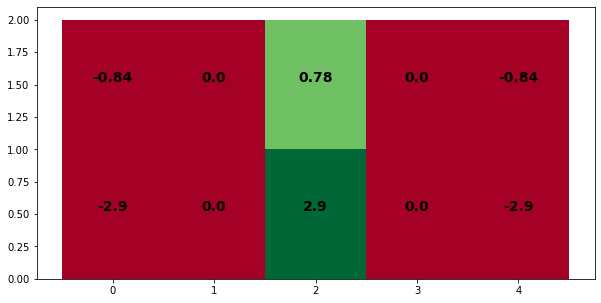

In [55]:
import matplotlib.pyplot as plt

def find_value(P,gamma= 0.9,k=2):
    value = np.zeros(env.nS)
    for _ in range(k):
        tmp = np.copy(value)
        for state, state_info in P.items():
            for action, action_info in state_info.items():
                for info in action_info:
                    prob, next_state, reward, done = info
                    value[state] += 0.25*(reward + gamma*prob*tmp[next_state])
    return value

def autolabel(rects, text, width, H):
    for i,rect in enumerate(rects):
        ax.text(width*i+width-1, H-0.5, round(text[i],2),
                ha='center', va='bottom',rotation=0, weight="heavy",wrap=True, fontsize=14)
value = find_value(env.P)
env.reset()
env.render()
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)

m = max(value)
for h in range(2):
    rects=[]
    for i in range(5):
        width = 1
        rects.append(ax.bar(width*i, [2-h], width, color=plt.get_cmap('RdYlGn')(value[i+5*h])))
    autolabel(rects,value[5*h:5*h+5], width, 2-h)

## Using OpenAI Gym <a name="openai">


In [56]:
import numpy as np
import gym

env = gym.make("FrozenLake-v0")

"""
Environment Description:
    The ice is slippery, so you won't always move in the direction you intend.
        SFFF
        FHFH
        FFFH
        HFFG
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    
    
    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.
    
    Actions are Left=0, Down=1, Right=2, Up=3
"""

print(f"The action space is {env.action_space}, and state space is {env.observation_space}\n")

#Reset our environment, returns the initial state
state = env.reset()
print(f"Our initial state is: {state}\n")
env.render() #shows the map

#Randomly sample an action
action = env.action_space.sample()
print(f"Taking an action: {action}")

#Take the action, and observe the changes
next_state, reward, done, _ = env.step(action)
print(f"The state we arrive at is {next_state}\n")
print(f"The reward we recieved is {reward}\n")
print(f"Are we done? {done}\n")
env.render()

#Transition probablity function
print(f"Probablity Transition Function = env.P = dict(state: dict(action: (prob, next_state, reward, done)))\n")
for state, state_info in env.P.items():
    print(f"In state = {state}")
    for action, action_info in state_info.items():
        print(f"""\tIf we take action {action},""")
        for info in action_info:
            prob, next_state, reward, done =info
            print(f"""\t\tWe have a probablity = {prob} of the next state being {next_state}, receiving reward = {reward}, and done = {done}""")

The action space is Discrete(4), and state space is Discrete(16)

Our initial state is: 0


SFFF
FHFH
FFFH
HFFG
Taking an action: 1
The state we arrive at is 4

The reward we recieved is 0.0

Are we done? False

  (Down)
SFFF
FHFH
FFFH
HFFG
Probablity Transition Function = env.P = dict(state: dict(action: (prob, next_state, reward, done)))

In state = 0
	If we take action 0,
		We have a probablity = 0.3333333333333333 of the next state being 0, receiving reward = 0.0, and done = False
		We have a probablity = 0.3333333333333333 of the next state being 0, receiving reward = 0.0, and done = False
		We have a probablity = 0.3333333333333333 of the next state being 4, receiving reward = 0.0, and done = False
	If we take action 1,
		We have a probablity = 0.3333333333333333 of the next state being 0, receiving reward = 0.0, and done = False
		We have a probablity = 0.3333333333333333 of the next state being 4, receiving reward = 0.0, and done = False
		We have a probablity = 0.3333333333333

In [57]:
def run(env, policy, n=1):
    wins = 0
    crewards = 0
    for _ in range(n):
        done = False
        state = env.reset()
        while not done:
            action = policy[state]
            next_state, reward, done, info = env.step(action)                        
            crewards += reward
            state = next_state            
        if reward == 1.0:
            wins += 1                
    print(f"""
            {'#'*20}\n
            Number of wins: {wins} out of {n} episodes\n
            Cumulative reward: {crewards} over {n} episodes\n
            Avg. reward per episode: {crewards/n}\n
            {'#'*20}
            """)
    
random_policy = np.array([env.action_space.sample() for _ in range(env.nS)])
print("Our policy:",random_policy, random_policy.shape)
run(env,random_policy, 100)

Our policy: [3 3 0 3 1 3 3 3 0 1 2 2 0 2 0 2] (16,)

            ####################

            Number of wins: 0 out of 100 episodes

            Cumulative reward: 0.0 over 100 episodes

            Avg. reward per episode: 0.0

            ####################
            



SFFF
FHFH
FFFH
HFFG


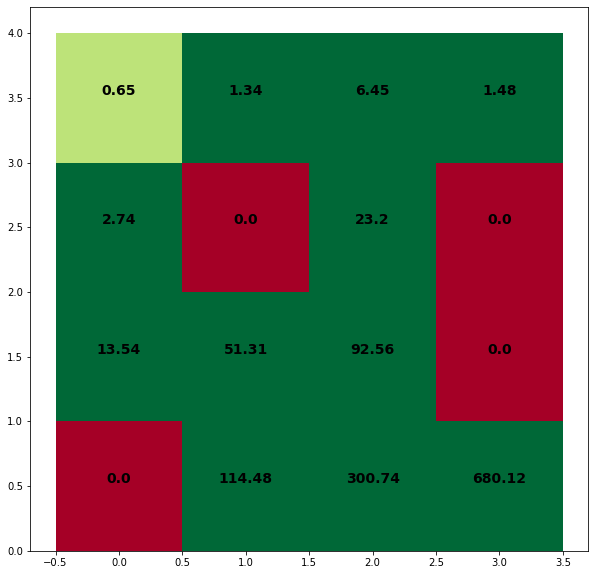

In [58]:
def find_value(P,gamma= 0.9,k=10):
    value = np.zeros(env.nS)
    for _ in range(k):
        tmp = np.copy(value)
        for state, state_info in P.items():
            for action, action_info in state_info.items():
                for info in action_info:
                    prob, next_state, reward, done = info
                    if state == 15:
                        reward = 1
                    value[state] += 0.25*(reward + gamma*prob*tmp[next_state])
    return value
value = find_value(env.P)

env.reset()
env.render()
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)

for h in range(4):
    rects=[]
    for i in range(4):
        width = 1
        rects.append(ax.bar(width*i, [4-h], width, color=plt.get_cmap('RdYlGn')(value[i+4*h])))
    autolabel(rects,value[4*h:4*h+4], width, 4-h)

# Dynamic Programming <a name="dynamicprogramming">

## Policy Iteration <a name="policyiteration">
    
    Policy Evaluation: Synchronous updates using epilson-convergence (1) and k-iterations (2)
    Policy Improvement: Implementation follows traditional approach
    Policy Iteration: Implementation follows traditional approach (Stopping condition = Policy stability)

In [59]:
#Using epilson-convergence
def policy_evaluation_1(policy, env, P, gamma=0.9, epilson=1e-3):
    value = np.zeros(env.nS)
    new_value = np.zeros(env.nS)
    while True:
        value = np.copy(new_value)
        for state in range(env.nS): #Performing a sweep across state space
            action = policy[state]
            transition = np.array(P[state][action])
            probs = transition[:,0]
            next_states = transition[:,1].astype(int)
            rewards = transition[:,2]
            new_value[state] = (rewards + gamma * probs * value[next_states]).sum()
        if np.abs(new_value-value).sum()<=epilson:
            break
    return new_value

#k iterations
def policy_evaluation_2(policy, env, P, gamma=0.9, k=100):
    value = np.zeros(env.nS)
    new_value = np.zeros(env.nS)
    for _ in range(k):
        value = np.copy(new_value)
        for state in range(env.nS): #Performing a sweep across state space
            action = policy[state]
            transition = np.array(P[state][action])
            probs = transition[:,0]
            next_states = transition[:,1].astype(int)
            rewards = transition[:,2]
            new_value[state] = (rewards + gamma * probs * value[next_states]).sum()
    return new_value

In [60]:
def policy_improvement(value, env, P, gamma=0.9):
    policy = np.zeros(env.nS)
    for state in range(env.nS):
        q = np.zeros(env.nA)
        for action in range(env.nA):
            transition = np.array(P[state][action])
            prob = transition[:,0]
            next_state = transition[:,1].astype(int)
            rewards = transition[:,2]
            q[action] = (prob * (rewards + gamma * value[next_state])).sum()
        policy[state] = q.argmax().astype(int)
    return policy

In [61]:
import numpy as np

def policy_iteration(env, gamma=0.9):
    #Initialization of policy and value
    policy = np.array([env.action_space.sample() for _ in range(env.nS)])
    P = env.P
    while True:
        value = policy_evaluation_1(policy, env, P, gamma)
        updated_policy = policy_improvement(value, env, P, gamma)
        if np.all(policy==updated_policy):
            break
        policy = np.copy(updated_policy)
    return updated_policy, value

In [62]:
env = gym.make("FrozenLake-v0")
policy, value = policy_iteration(env)
%time run(env,policy,100)


            ####################

            Number of wins: 76 out of 100 episodes

            Cumulative reward: 76.0 over 100 episodes

            Avg. reward per episode: 0.76

            ####################
            
CPU times: user 54.9 ms, sys: 0 ns, total: 54.9 ms
Wall time: 54.9 ms



SFFF
FHFH
FFFH
HFFG


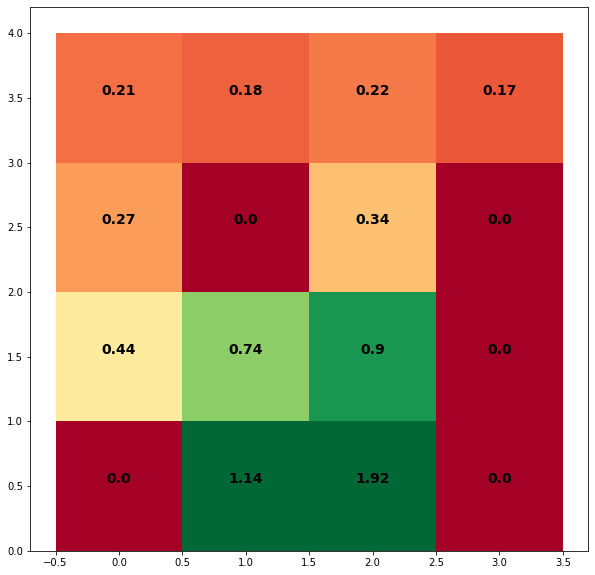

In [63]:
env.reset()
env.render()
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)

H,W = 4,4

for h in range(H):
    rects=[]
    for i in range(W):
        width = 1
        rects.append(ax.bar(width*i, [H-h], width, color=plt.get_cmap('RdYlGn')(value[i+4*h])))
    autolabel(rects,value[H*h:H*h+W], width, H-h)

## Value Iteration <a name="valueiteration">

In [64]:
import numpy as np

def find_value(env, P, gamma=0.9, epilson=1e-12):
    value = np.zeros(env.nS)
    new_value = np.zeros(env.nS)
    while True:
        value = np.copy(new_value)
        for state in range(env.nS): #Performing a sweep across state-action space
            q = np.zeros(env.nA)
            for action in range(env.nA):
                transition = np.array(P[state][action])
                prob = transition[:,0]
                next_state = transition[:,1].astype(int)
                rewards = transition[:,2]
                q[action] =  (prob * (rewards + gamma * value[next_state])).sum()
            new_value[state] = q.max()
        if np.abs(new_value-value).sum()<=epilson:
            break
    return new_value

def get_policy(value, env, P, gamma=0.9):
    policy = np.zeros(env.nS)
    for state in range(env.nS):
        q = np.zeros(env.nA)
        for action in range(env.nA):
            transition = np.array(P[state][action])
            prob = transition[:,0]
            next_state = transition[:,1].astype(int)
            rewards = transition[:,2]
            q[action] =  (prob * (rewards + gamma * value[next_state])).sum()
        policy[state] = q.argmax()
    return policy

def value_iteration(env, gamma=0.9):
    P = env.P
    value = find_value(env, P, gamma)
    policy = get_policy(value, env, P, gamma)
    return policy, value

In [65]:
env = gym.make("FrozenLake-v0")

policy, value = value_iteration(env, gamma=1)

%time run(env,policy,100)


            ####################

            Number of wins: 67 out of 100 episodes

            Cumulative reward: 67.0 over 100 episodes

            Avg. reward per episode: 0.67

            ####################
            
CPU times: user 89.4 ms, sys: 0 ns, total: 89.4 ms
Wall time: 89.5 ms



SFFF
FHFH
FFFH
HFFG


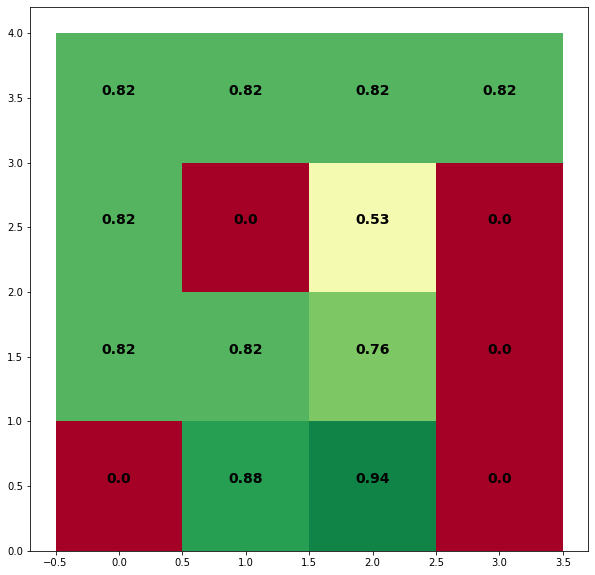

In [66]:
env.reset()
env.render()
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)

H,W = 4,4

for h in range(H):
    rects=[]
    for i in range(W):
        width = 1
        rects.append(ax.bar(width*i, [H-h], width, color=plt.get_cmap('RdYlGn')(value[i+4*h])))
    autolabel(rects,value[H*h:H*h+W], width, H-h)

# Monte Carlo Methods <a name="montecarlo">

In [67]:
from collections import defaultdict
import gym
import numpy as np

env = gym.make("Blackjack-v0")
env.reset()

print(f"""Environment: BlackJack\n
Cards: Face cards (Jack, Queen, King) have point value 10.\n\tAces can either count as 11 or 1, and it's called 'usable' at 11.\n
Example of observation: {env._get_obs()}\n
Number of actions: {env.action_space.n}\n
Player's cards: {env.player}\n
Dealer's cards: {env.dealer}""")


def run(env, policy):
    win = 0
    for episode in range(10000):
        done = False
        state = env.reset()
        while not done:
            action = policy[state]
            next_state, reward, done, info = env.step(action)                        
            if reward>=1:
              win +=1
            state = next_state                          
    print(f"Winning Percentage: {win/10000 * 100} %")

policy = defaultdict(env.action_space.sample)
print("\n\nRUNNING A RANDOM POLICY")
run(env,policy)

Environment: BlackJack

Cards: Face cards (Jack, Queen, King) have point value 10.
	Aces can either count as 11 or 1, and it's called 'usable' at 11.

Example of observation: (12, 6, False)

Number of actions: 2

Player's cards: [8, 4]

Dealer's cards: [6, 7]


RUNNING A RANDOM POLICY
Winning Percentage: 28.999999999999996 %


## First-Visit Monte Carlo Method with Exploring Starts + Incremental Updates <a name="fesimc">

In [68]:
def get_all_possible_state():
    states = []
    for player_card1 in range(1,10+1):
        for player_card2 in range(1,10+1):
            for dealer_card1 in range(1,10+1):
                for dealer_card2 in range(1,10+1):
                    states.append([player_card1,player_card2,
                                   dealer_card1,dealer_card2])
    return states

env.player = [4,1,2]
env.dealer = [2,3,4]
print(env._get_obs())

states = get_all_possible_state()
print("Number of possible states:",len(states))

arg = np.random.choice(len(states))
env.player = states[arg][:2]
env.dealer = states[arg][2:]
print(f"Players:{states[arg][:2]}, Dealer:{states[arg][2:]}")
print(env._get_obs())

(17, 2, True)
Number of possible states: 10000
Players:[1, 5], Dealer:[2, 9]
(16, 2, True)


In [69]:
from tqdm import tqdm

def fesi_mc(env, gamma = 0.98, k=10, ne=1000):
    qvalue = defaultdict(float) 
    policy = defaultdict(env.action_space.sample)
    pb = tqdm(range(k))
    for i in pb:
        all_possible_states = get_all_possible_state()
        N = defaultdict(int)
        
        for n in range(ne):
            if not n%1000: pb.set_description(f"{i}: {n}/{ne}")
            #Exploring Start + Create Episode
            arg = np.random.choice(len(all_possible_states)) #Select a starting state with equal prob.
            start_state = all_possible_states[arg]
            all_possible_states.pop(arg) #Sampling without replacement
            episode = create_episode(env,start_state,policy) #Create a episode   
            
            #Policy Evaluation over One Episode
            visited = []
            G = 0
            for t, (obs, action, reward) in enumerate(episode):
                if (obs,action) not in visited:
                    N[(obs,action)] += 1
                    visited.append((obs,action))
                    G = gamma*G + reward
                    #Incremental QValue Improvement
                    qvalue[(obs,action)] += 1/N[(obs,action)] * (G - qvalue[(obs,action)])
            
        #Greedy Policy Improvement
        seen_sa = list(qvalue.keys())
        for (obs,_) in seen_sa:
            policy[obs] = np.argmax([qvalue[(obs,action)] for action in range(env.action_space.n)])
    return policy

def create_episode(env, start_state, policy):
    env.player = start_state[:2]
    env.dealer = start_state[2:]
    obs = env._get_obs()
    action = policy[tuple(obs)]
    next_obs, reward, done, _ = env.step(action)
    episode = [(next_obs,action,reward)]
    while not done:
        obs = next_obs
        action = policy[tuple(obs)]
        next_obs, reward, done, _ = env.step(action)
        episode.append((next_obs,action,reward))
    return episode

In [70]:
env = gym.make("Blackjack-v0")
policy = fesi_mc(env,k=8, ne=9000)

run(env,policy)

7: 8000/9000: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Winning Percentage: 37.24 %


## Every-Visit Monte Carlo Method with epilson-soft Policy + Incremental Updates <a name="eegimc">

In [71]:
def act(env, policy, obs, epilson = 0.1):
    if epilson>np.random.random():
        return env.action_space.sample()
    return policy[obs]

In [72]:
def eegi_mc(env, gamma = 0.98, k=10, ne=1000, epilson=0.1):
    qvalue = defaultdict(float) 
    policy = defaultdict(env.action_space.sample)
    pb = tqdm(range(k))
    for i in pb:
        N = defaultdict(int)
        for n in range(ne):
            episode = create_episode(env,policy,epilson) #Create a episode   
            #Policy Evaluation over One Episode
            G = 0
            for t, (obs, action, reward) in enumerate(episode):
                N[(obs,action)] += 1
                G = gamma*G + reward
                #Incremental QValue Improvement
                qvalue[(obs,action)] += 1/N[(obs,action)] * (G - qvalue[(obs,action)])
        #Greedy Policy Improvement
        seen_sa = list(qvalue.keys())
        for (obs,_) in seen_sa:
            policy[obs] = np.argmax([qvalue[(obs,action)] for action in range(env.action_space.n)])
    return policy

def create_episode(env, policy, epilson = 0.1):
    obs = env.reset()
    action = act(env, policy, obs, epilson)
    next_obs, reward, done, _ = env.step(action)
    episode = [(next_obs,action,reward)]
    while not done:
        obs = next_obs
        action = act(env, policy, obs, epilson)
        next_obs, reward, done, _ = env.step(action)
        episode.append((next_obs,action,reward))
    return episode

In [73]:
env = gym.make("Blackjack-v0")
policy = eegi_mc(env,k=20, ne=3000)
run(env,policy)

100%|██████████| 20/20 [00:07<00:00,  2.64it/s]


Winning Percentage: 39.22 %


## Off-policy Monte Carlo Method with Importance Sampling <a name="mcopis">

In [74]:
from functools import partial 
from scipy.special import softmax

class Policy():
    def __init__(self, action_probs):
        self.P = action_probs
    def act(self, state):
        return np.random.choice(list(self.P[state].keys()),
                                p=softmax(list(self.P[state].values())))
    def update_prob(self, action_probs):
        self.P = action_probs
    def __getitem__(self, state):
        return np.argmax(self.P[state].values())

def init_action_prob(env, prob):
    return {action: prob for action in range(env.action_space.n)}

action_probs = defaultdict(partial(init_action_prob, env=env, prob = 0.5))
bp = Policy(action_probs)
for _ in range(10):
    obs = env.reset()
    print(obs, bp.P[obs])

(12, 7, False) {0: 0.5, 1: 0.5}
(17, 4, False) {0: 0.5, 1: 0.5}
(9, 10, False) {0: 0.5, 1: 0.5}
(17, 10, False) {0: 0.5, 1: 0.5}
(16, 1, False) {0: 0.5, 1: 0.5}
(14, 10, False) {0: 0.5, 1: 0.5}
(21, 10, True) {0: 0.5, 1: 0.5}
(11, 8, False) {0: 0.5, 1: 0.5}
(12, 10, False) {0: 0.5, 1: 0.5}
(14, 10, False) {0: 0.5, 1: 0.5}


In [75]:
def is_mc(env, gamma = 0.98, k=10, ne=1000, epilson=1e-12):
    qvalue = defaultdict(float) 
    
    """
    Create behavioral (stochastic) policy and target (deterministic) policy
    Assume target to be epilson-greedy for importance sampling ratio calculations 
    """
    
    action_probs = defaultdict(partial(init_action_prob, env=env, prob = 0.5))
    bp = Policy(action_probs)
    tp = defaultdict(env.action_space.sample)
    
    pb = tqdm(range(k))
    for i in pb:
        N = defaultdict(int)
        for n in range(ne):
            episode = create_episode(env,bp,epilson) #Create a episode   
            #Policy Evaluation over One Episode
            G = 0
            for t, (obs, action, reward) in enumerate(episode):
                N[(obs,action)] += 1
                G = gamma*G + reward
                #Incremental QValue Improvement
                is_ratio = (1.0-epilson)/bp.P[obs][action] if tp[obs]==action else epilson/bp.P[obs][action]
                qvalue[(obs,action)] += 1/N[(obs,action)] * is_ratio * (G - qvalue[(obs,action)])
        #Greedy Policy Improvement
        seen_sa = list(qvalue.keys())
        for (obs,_) in seen_sa:
            tp[obs] = np.argmax([qvalue[(obs,action)] for action in range(env.action_space.n)])
    return policy
            
def create_episode(env, policy, epilson = 0.1):
    obs = env.reset()
    action = policy.act(obs)
    next_obs, reward, done, _ = env.step(action)
    episode = [(next_obs,action,reward)]
    while not done:
        obs = next_obs
        action = policy.act(obs)
        next_obs, reward, done, _ = env.step(action)
        episode.append((next_obs,action,reward))
    return episode

In [76]:
env = gym.make("Blackjack-v0")
policy = is_mc(env, k=20, ne=1000)
run(env,policy)

100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


Winning Percentage: 38.47 %


# Temporal Difference Learning <a name = "tdlearning">

In [77]:
from gym_maze.envs.maze_env import MazeEnvRandom3x3
from collections import defaultdict

class Maze3x3Env(MazeEnvRandom3x3):
    def __init__(self):
        super(Maze3x3Env,self).__init__(enable_render=False)
        self.enable_render = False
    def step(self,action):
        next_obs, reward, done, _ = super().step(action)
        return tuple(next_obs.astype(int)), reward, done, _
    def reset(self):
        return tuple(super().reset().astype(int))
        

env = Maze3x3Env()
print(f"""Environment: Maze 3x3\n
Example of observation: {env.reset()}\n
Number of actions: {env.action_space.n}\n""")

def run(env,policy, k=1000):
    crewards = 0
    done = False
    state = env.reset()
    for i in range(k):
        action = policy[state]
        next_state, reward, done, info = env.step(action)                        
        crewards += reward
        state = next_state      
        if done:
            break
    print(f"Ran for {i} steps with cumulative reward:", crewards)
    
policy = defaultdict(env.action_space.sample)
run(env,policy)

Environment: Maze 3x3

Example of observation: (0, 0)

Number of actions: 4

Ran for 999 steps with cumulative reward: -11.111111111111075


## SARSA <a name="sarsa">

In [78]:
import numpy as np
from tqdm import tqdm
import random

def egreedy(env, value, obs ,epilson=0.5):
    if epilson>np.random.random():
        return env.action_space.sample()
    return int(np.argmax([value[(obs,action)] for action in range(env.action_space.n)]))

def sarsa(env, k=1, alpha=0.7, gamma = 0.99):
    qvalue = defaultdict(float)
    obs = env.reset()
    pb = tqdm(range(k))
    for i in pb:
        action = egreedy(env,qvalue,obs)
        next_obs, reward, done, _ = env.step(action)
        next_action = egreedy(env,qvalue,next_obs, epilson=0)
        qvalue[(obs,action)] += alpha * (reward + gamma * qvalue[(next_obs,next_action)] - qvalue[obs, action])
        obs = next_obs
        if done:
            obs = env.reset()
    
    policy = defaultdict(env.action_space.sample)
    for obs in set(np.array(list(qvalue.keys()))[:,0]):
        policy[obs]=int(np.argmax([qvalue[(obs,action)] for action in range(env.action_space.n)]))
    return policy, qvalue

env = Maze3x3Env()
policy, qvalue = sarsa(env, k=150)
run(env,policy)

100%|██████████| 150/150 [00:00<00:00, 8830.73it/s]

Ran for 3 steps with cumulative reward: 0.9666666666666667


In [79]:
from gym_maze.envs.maze_env import MazeEnvRandom5x5

class Maze5x5Env(MazeEnvRandom5x5):
    def __init__(self):
        super(Maze5x5Env,self).__init__(enable_render=False)
        self.enable_render = False
    def step(self,action):
        next_obs, reward, done, _ = super().step(action)
        return tuple(next_obs.astype(int)), reward, done, _
    def reset(self):
        return tuple(super().reset().astype(int))

env = Maze5x5Env()
policy, qvalue = sarsa(env, k=850)
run(env,policy)

100%|██████████| 850/850 [00:00<00:00, 7974.35it/s]

Ran for 7 steps with cumulative reward: 0.972


In [80]:
from gym_maze.envs.maze_env import MazeEnvRandom30x30Plus

class Maze30x30EnvP(MazeEnvRandom30x30Plus):
    def __init__(self):
        super(Maze30x30EnvP,self).__init__(enable_render=False)
        self.enable_render = False
    def step(self,action):
        next_obs, reward, done, _ = super().step(action)
        return tuple(next_obs.astype(int)), reward, done, _
    def reset(self):
        return tuple(super().reset().astype(int))

In [81]:
env = Maze30x30EnvP()
policy, qvalue = sarsa(env, k=1000000)
run(env,policy)

100%|██████████| 1000000/1000000 [01:42<00:00, 9803.42it/s]

Ran for 24 steps with cumulative reward: 0.9973333333333333


## Expected SARSA <a name="esarsa">

In [82]:
def expected_sarsa(env, k=1000, alpha=0.9, gamma = 0.98, epilson=0.5):
    qvalue = defaultdict(float)
    obs = env.reset()
    pb = tqdm(range(k))
    for i in pb:
        action = egreedy(env,qvalue,obs, 1/(i+1))
        next_obs, reward, done, _ = env.step(action)
        qvalue[(obs,action)] += alpha * (reward + gamma * expectation(env, qvalue, next_obs, epilson) - qvalue[obs, action])
        obs = next_obs
        if done:
            state = env.reset()
    
    policy = defaultdict(env.action_space.sample)
    for obs in set(np.array(list(qvalue.keys()))[:,0]):
        policy[obs]=int(np.argmax([qvalue[(obs,action)] for action in range(env.action_space.n)]))
    return policy, qvalue

def expectation(env, qvalue, obs, epilson):
    values = [qvalue[(obs,a)] for a in range(env.action_space.n)]
    prob = np.ones(env.action_space.n) * epilson/env.action_space.n
    prob[np.argmax(values)]+=1-epilson
    return np.sum(prob*values)

env = Maze3x3Env()
policy, qvalue = expected_sarsa(env, k=80)
run(env,policy)

100%|██████████| 80/80 [00:00<00:00, 9082.76it/s]

Ran for 3 steps with cumulative reward: 0.9666666666666667


In [83]:
env = Maze5x5Env()
policy, qvalue = expected_sarsa(env, k=750)
run(env,policy)

100%|██████████| 750/750 [00:00<00:00, 6228.95it/s]

Ran for 7 steps with cumulative reward: 0.972


In [84]:
env = Maze30x30EnvP()
policy, qvalue = expected_sarsa(env, k=500000)
run(env,policy)

100%|██████████| 500000/500000 [01:19<00:00, 6328.88it/s] 

Ran for 38 steps with cumulative reward: 0.9957777777777778


## Q-Learning <a name="ql">

In [85]:
def q_learning(env, k=1, alpha=0.5, gamma = 0.98):
    qvalue = defaultdict(float)
    obs = env.reset()
    pb = tqdm(range(k))
    for i in pb:
        action = egreedy(env, qvalue, obs, 1/(i+1))
        next_obs, reward, done, _ = env.step(action)
        target = np.max([qvalue[(next_obs,a)] for a in range(env.action_space.n)])
        qvalue[obs, action] += alpha * (reward + gamma * target - qvalue[obs, action])
        obs = next_obs
        if done:
            obs = env.reset()
    
    policy = defaultdict(env.action_space.sample)
    for obs in set(np.array(list(qvalue.keys()))[:,0]):
        policy[obs]=int(np.argmax([qvalue[(obs,action)] for action in range(env.action_space.n)]))
    return policy, qvalue

env = Maze3x3Env()
policy, qvalue = q_learning(env, k=200)
run(env,policy)

100%|██████████| 200/200 [00:00<00:00, 5736.78it/s]

Ran for 3 steps with cumulative reward: 0.9666666666666667


## Double Q-Learning <a name="dl">

In [86]:
def double_q_learning(env, k=1, alpha=0.5, gamma = 0.98):
    qvalue1 = defaultdict(float)
    qvalue2 = defaultdict(float)
    obs = env.reset()
    pb = tqdm(range(k))
    for i in pb:
        action = epilsongreedy(env, qvalue1, qvalue2, obs, 1/(i+1))
        next_obs, reward, done, _ = env.step(action)
        if np.random.rand()>0.5:
            target = np.max([qvalue2[(next_obs,a)] for a in range(env.action_space.n)])
            qvalue1[obs, action] += alpha * (reward + gamma * target - qvalue1[obs, action])
        else:
            target = np.max([qvalue1[(next_obs,a)] for a in range(env.action_space.n)])
            qvalue2[obs, action] += alpha * (reward + gamma * target - qvalue2[obs, action])
        obs = next_obs
        if done:
            obs = env.reset()
            
    policy = defaultdict(env.action_space.sample)
    all_obs = set(np.concatenate([list(qvalue1.keys()),list(qvalue2.keys())])[:,0])
    for obs in all_obs:
        policy[obs]=int(np.argmax([(qvalue1[(obs,action)]+qvalue2[(obs,action)])/2 for action in range(env.action_space.n)]))
    return policy, qvalue1, qvalue2

def epilsongreedy(env,qvalue1,qvalue2,state,epilson=0.4):
    if epilson>np.random.random():
        return env.action_space.sample()
    return int(np.argmax([(qvalue1[(state,action)]+qvalue2[(state,action)])/2 for action in range(env.action_space.n)]))

env = Maze3x3Env()
policy, qvalue1, qvalue2 = double_q_learning(env, k=200)
run(env,policy)

100%|██████████| 200/200 [00:00<00:00, 6127.19it/s]

Ran for 3 steps with cumulative reward: 0.9666666666666667


# n-Step Bootstrapping <a name="nsbs">

## n-Step SARSA <a name="nsarsa">

In [87]:
def egreedy(env, value, obs ,epilson=0.5):
    if epilson>np.random.random():
        return env.action_space.sample()
    return int(np.argmax([value[(obs,action)] for action in range(env.action_space.n)]))

def nstep_sarsa(env, k=1, n=10, alpha=0.5, gamma = 0.99):
    qvalue = defaultdict(float)
    obs = env.reset()
    pb = tqdm(range(k))
    buffer = []
    for i in pb:
        action = egreedy(env,qvalue,obs)
        next_obs, reward, done, _ = env.step(action)
        next_action = egreedy(env,qvalue,next_obs, epilson=1)
        if len(buffer)==n-1:
            G = 0
            for r in reversed(buffer):
                G = gamma*G + r
            G += gamma**(n-1) * reward + gamma**n * qvalue[next_obs, next_action]
            qvalue[(obs,action)] += alpha * (G - qvalue[obs, action])
            buffer = []
        else:
            buffer.append(reward)
        obs = next_obs
        if done:
            obs = env.reset()
            buffer = []
    
    policy = defaultdict(env.action_space.sample)
    for obs in set(np.array(list(qvalue.keys()))[:,0]):
        policy[obs]=int(np.argmax([qvalue[(obs,action)] for action in range(env.action_space.n)]))
    return policy, qvalue
        
def egreedy(env, value, obs ,epilson=0.5):
    if epilson>np.random.random():
        return env.action_space.sample()
    return int(np.argmax([value[(obs,action)] for action in range(env.action_space.n)]))
    
env = Maze3x3Env()
policy, qvalue = nstep_sarsa(env, n=9, k=200*9)
run(env,policy)

100%|██████████| 1800/1800 [00:00<00:00, 7936.84it/s]

Ran for 999 steps with cumulative reward: -11.111111111111075


In [ ]:
print("End")